In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from tqdm import tqdm
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import hashlib
from collections import defaultdict

USE_GPU = True
dtype = torch.float32 # We will be using float

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


In [4]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder

# Define a transform without normalization
transform = transforms.Compose([
    transforms.ToTensor()  # Convert NumPy array to PyTorch tensor
])

# Step 2: Define a custom Dataset
class NumpyDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X  # Keep as NumPy array
        self.transform = transform  # Store the transform
        
        # Convert string labels into numeric using LabelEncoder
        self.label_encoder = LabelEncoder()
        self.Y = [str(y[0]) for y in Y]  # Ensure Y is a list of strings
        self.classes = list(sorted(set(self.Y)))  # Unique class names
        self.Y = self.label_encoder.fit_transform(self.Y)  # Convert to numeric labels

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # NumPy array
        y = self.Y[idx]  # Numeric label (integer)

        # Apply the transform to the image if provided
        if self.transform:
            x = self.transform(x)

        return x, y


# Define the batch size
batch_size = 64

dataset_path = "../../../sign_datasets/27-class-sign-language-dataset/"
# Step 1: Load the .npy files
X = np.load(dataset_path + "X.npy")  # Shape: (Samples, H, W, C), dtype: float
Y = np.load(dataset_path + "Y.npy")  # Shape: (Samples, 1), dtype: str

# Step 3: Instantiate the dataset
# Instantiate the dataset with the transform
dataset = NumpyDataset(X, Y, transform=transform)

# Step 4: Split the dataset into train, validation, and test sets
total_samples = len(dataset)
train_size = int(0.7 * total_samples)  # 70% for training
val_size = int(0.2 * total_samples)    # 20% for validation
test_size = total_samples - train_size - val_size  # Remaining for testing

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Step 5: Print the sizes of each split
print(f"Total samples: {total_samples}")
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

# Step 6: Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 7: Verify DataLoaders by iterating through one batch
for images, labels in train_loader:
    print("Batch of images:", images.shape)  # Should be [batch_size, C, H, W]
    print("Batch of labels:", labels[:5])  # Show first 5 labels
    break  # Show only the first batch


Total samples: 22801
Training set size: 15960
Validation set size: 4560
Test set size: 2281
Batch of images: torch.Size([64, 3, 128, 128])
Batch of labels: tensor([20, 11,  3,  1, 18])


In [5]:
# Iterate through a few samples to get their dimensions
for idx, (image, label) in enumerate(dataset):
    if idx >= 10:  # Limit to 10 samples
        break
    # Get dimensions from the PyTorch tensor
    channels, height, width = image.shape  # Tensors have shape (C, H, W)
    print(f"Image {idx + 1}: Width={width}, Height={height}, Channels={channels}")

Image 1: Width=128, Height=128, Channels=3
Image 2: Width=128, Height=128, Channels=3
Image 3: Width=128, Height=128, Channels=3
Image 4: Width=128, Height=128, Channels=3
Image 5: Width=128, Height=128, Channels=3
Image 6: Width=128, Height=128, Channels=3
Image 7: Width=128, Height=128, Channels=3
Image 8: Width=128, Height=128, Channels=3
Image 9: Width=128, Height=128, Channels=3
Image 10: Width=128, Height=128, Channels=3


In [6]:
# Create a DataLoader to iterate through the dataset
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Compute mean and std
mean = torch.zeros(3)
std = torch.zeros(3)
total_pixels = 0

# The dimensions in images.size() represent:

# 0 (Batch Dimension): The number of images in a batch.
# 1 (Channel Dimension): The color channels (e.g., RGB: 3 channels).
# 2 (Height): The height of the image.
# 3 (Width): The width of the image.

print("Computing mean and std...")

# Iterate over the DataLoader to process the images in batches
for images, _ in tqdm(loader):
    # Calculate the total number of pixels in the batch for all channels
    # images.size(0) -> Number of images in the batch (batch size)
    # images.size(2) -> Height of each image
    # images.size(3) -> Width of each image
    # Multiply these together to get the total pixels per image across all channels
    total_pixels += images.size(0) * images.size(2) * images.size(3)

    # Accumulate the sum of pixel values for each channel (R, G, B)
    # dim=[0, 2, 3] -> Sum over batch, height, and width dimensions
    # Result is a tensor with the sum for each channel
    mean += images.sum(dim=[0, 2, 3])

    # Accumulate the sum of squared pixel values for each channel
    # This is used later to calculate the standard deviation
    std += (images ** 2).sum(dim=[0, 2, 3])

# Finalize mean by dividing the accumulated sum by the total number of pixels
mean /= total_pixels

# Finalize std by first calculating variance (sum of squared differences / total pixels)
# Then take the square root to get the standard deviation
std = torch.sqrt(std / total_pixels)

# Print the computed mean and std for all channels
print(f"Computed Mean: {mean.tolist()}")
print(f"Computed Std: {std.tolist()}")

Computing mean and std...


100%|██████████| 357/357 [00:03<00:00, 93.38it/s] 

Computed Mean: [0.5108343362808228, 0.47160401940345764, 0.43902790546417236]
Computed Std: [0.5867133736610413, 0.5466195344924927, 0.5143911242485046]


In [ ]:
# Already computed mean and std
computed_mean = [0.5108343362808228, 0.47160401940345764, 0.43902790546417236]
computed_std = [0.5867133736610413, 0.5466195344924927, 0.5143911242485046]

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),       # Convert images to PyTorch tensors
    transforms.Normalize(mean=computed_mean, std=computed_std)  # Normalize
])

# Create the dataset
dataset = NumpyDataset(X, Y, transform=transform)

# Define class names based on unique labels in Y
class_names = list(set([str(y[0]) for y in Y]))
print("Class names:", class_names)

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example of iterating through the train DataLoader
for images, labels in train_loader:
    print("Train Batch - Images shape:", images.shape)
    print("Train Batch - Labels:", labels[:5])  # Print first 5 labels
    break

# Print dataset sizes for verification
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Print DataLoader sizes for verification
print(f"Train DataLoader size: {len(train_loader)}")
print(f"Validation DataLoader size: {len(val_loader)}")
print(f"Test DataLoader size: {len(test_loader)}")

Class names: ['8', 'yes', 'please', 'little bit', 'no', 'd', '1', '5', 'good', '4', '2', 'project', 'hello', '6', 'b', 'a', '9', '7', 'bye', 'e', 'c', 'pardon', 'whats up', '3', '0', 'NULL', 'good morning']
Train Batch - Images shape: torch.Size([64, 3, 128, 128])
Train Batch - Labels: tensor([ 0, 12, 18,  9,  9])
Train set size: 15960
Validation set size: 4560
Test set size: 2281
Train DataLoader size: 250
Validation DataLoader size: 72
Test DataLoader size: 36


In [10]:
from collections import Counter
import matplotlib.pyplot as plt

def get_class_distribution(loader, label_encoder):
    """
    Computes the distribution of classes in a DataLoader.

    Args:
    - loader: DataLoader to inspect
    - label_encoder: LabelEncoder used to encode the labels

    Returns:
    - class_counts: Dictionary with class names as keys and counts as values
    """
    class_counts = Counter()
    
    # Loop through the DataLoader
    for _, labels in loader:
        # Decode numeric labels back to class names (strings)
        class_names = label_encoder.inverse_transform(labels.numpy())
        class_counts.update(class_names)

    # Convert to a dictionary with class names
    return dict(class_counts)

def display_class_distribution(distribution, title="Class Distribution"):
    """
    Displays the class distribution as a bar chart.

    Args:
    - distribution: Dictionary with class names as keys and counts as values
    - title: Title for the bar chart
    """
    class_names = list(distribution.keys())
    counts = list(distribution.values())

    plt.figure(figsize=(12, 6))
    plt.bar(class_names, counts, color='skyblue')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Train DataLoader Distribution:
  9: 613
  hello: 623
  0: 589
  a: 608
  4: 588
  8: 601
  little bit: 584
  project: 619
  pardon: 636
  please: 604
  yes: 630
  bye: 591
  2: 632
  7: 585
  3: 631
  d: 618
  good morning: 588
  6: 599
  e: 601
  no: 601
  1: 604
  good: 622
  whats up: 592
  b: 609
  c: 575
  5: 593
  NULL: 224


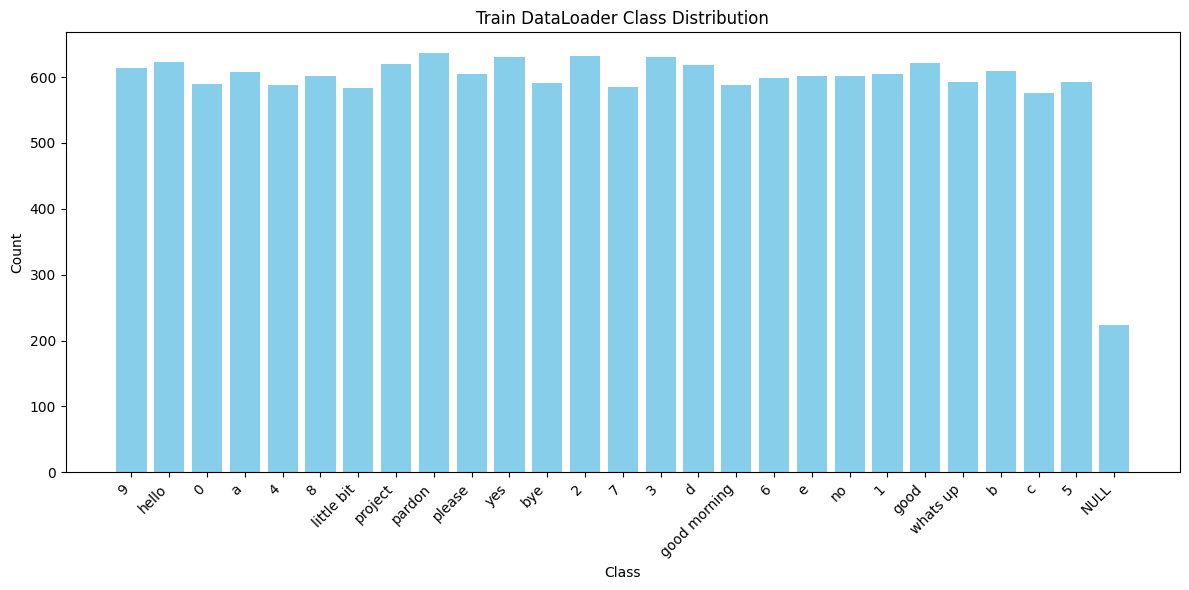

Validation DataLoader Distribution:
  9: 169
  0: 184
  good morning: 191
  2: 149
  6: 175
  1: 176
  hello: 165
  7: 198
  little bit: 192
  4: 189
  whats up: 174
  project: 167
  e: 171
  please: 172
  bye: 179
  a: 157
  5: 177
  8: 176
  c: 210
  3: 169
  good: 145
  NULL: 56
  no: 172
  yes: 169
  pardon: 149
  d: 158
  b: 171


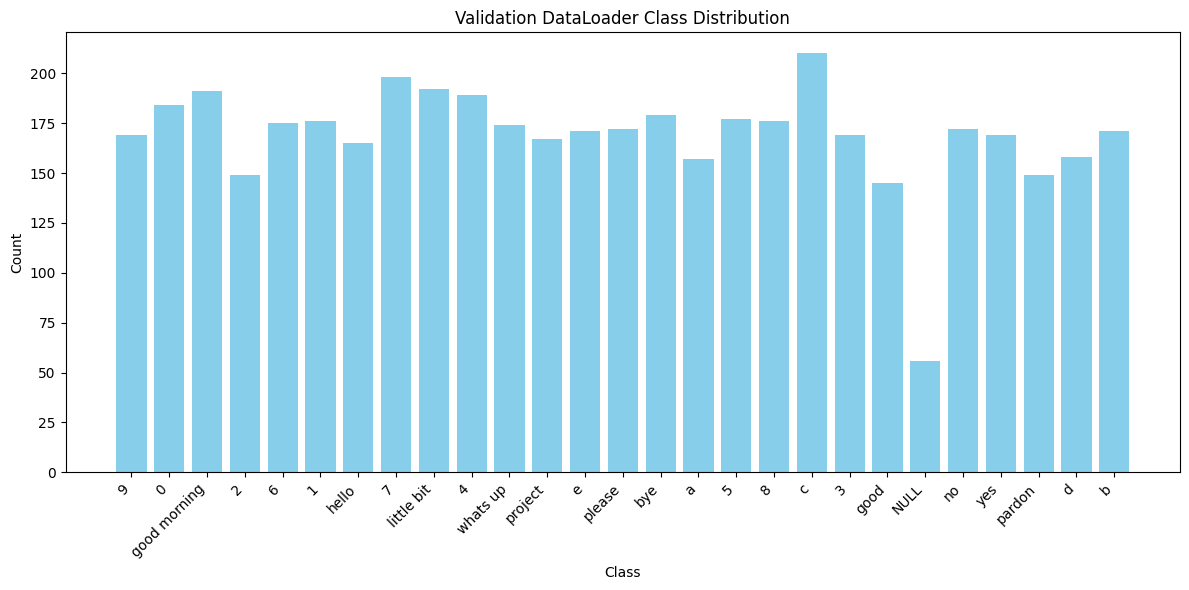

Test DataLoader Distribution:
  good: 98
  bye: 95
  9: 83
  4: 87
  good morning: 86
  e: 91
  NULL: 34
  b: 86
  2: 84
  please: 89
  little bit: 89
  no: 92
  8: 88
  c: 80
  0: 93
  7: 82
  5: 95
  pardon: 80
  whats up: 99
  1: 85
  a: 98
  6: 91
  hello: 77
  project: 79
  d: 89
  yes: 66
  3: 65


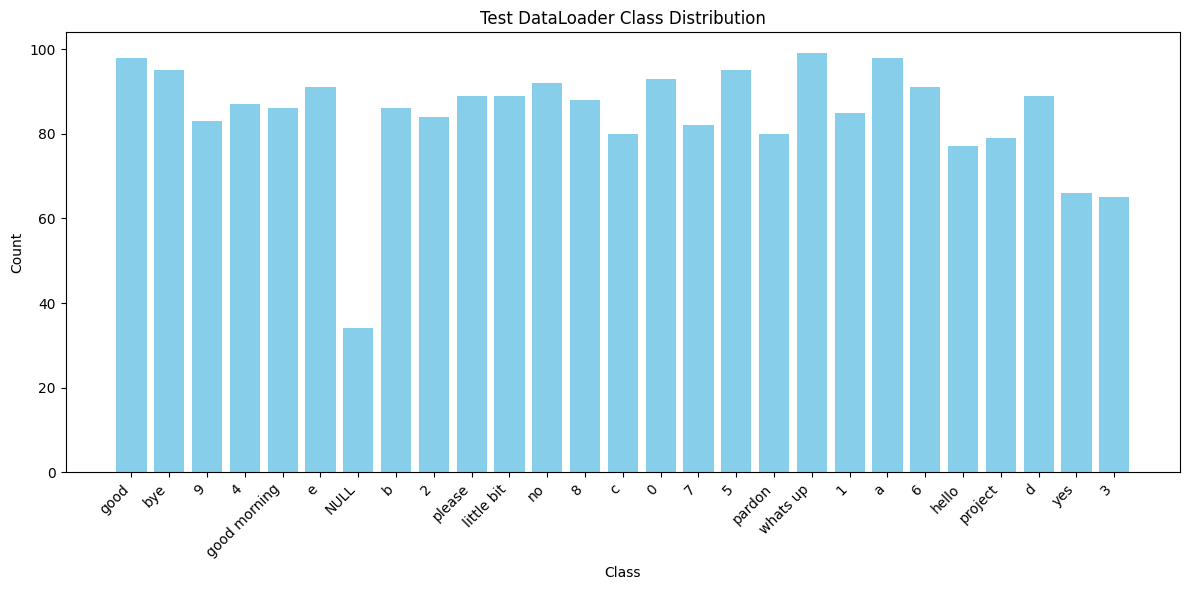

In [11]:
# Compute and display class distribution for each DataLoader
for loader, name in [(train_loader, "Train"), (val_loader, "Validation"), (test_loader, "Test")]:
    # Get class distribution using the label encoder from the dataset
    distribution = get_class_distribution(loader, dataset.label_encoder)
    
    # Print the class distribution
    print(f"{name} DataLoader Distribution:")
    for cls, count in distribution.items():
        print(f"  {cls}: {count}")
    
    # Display the class distribution as a bar chart
    display_class_distribution(distribution, title=f"{name} DataLoader Class Distribution")


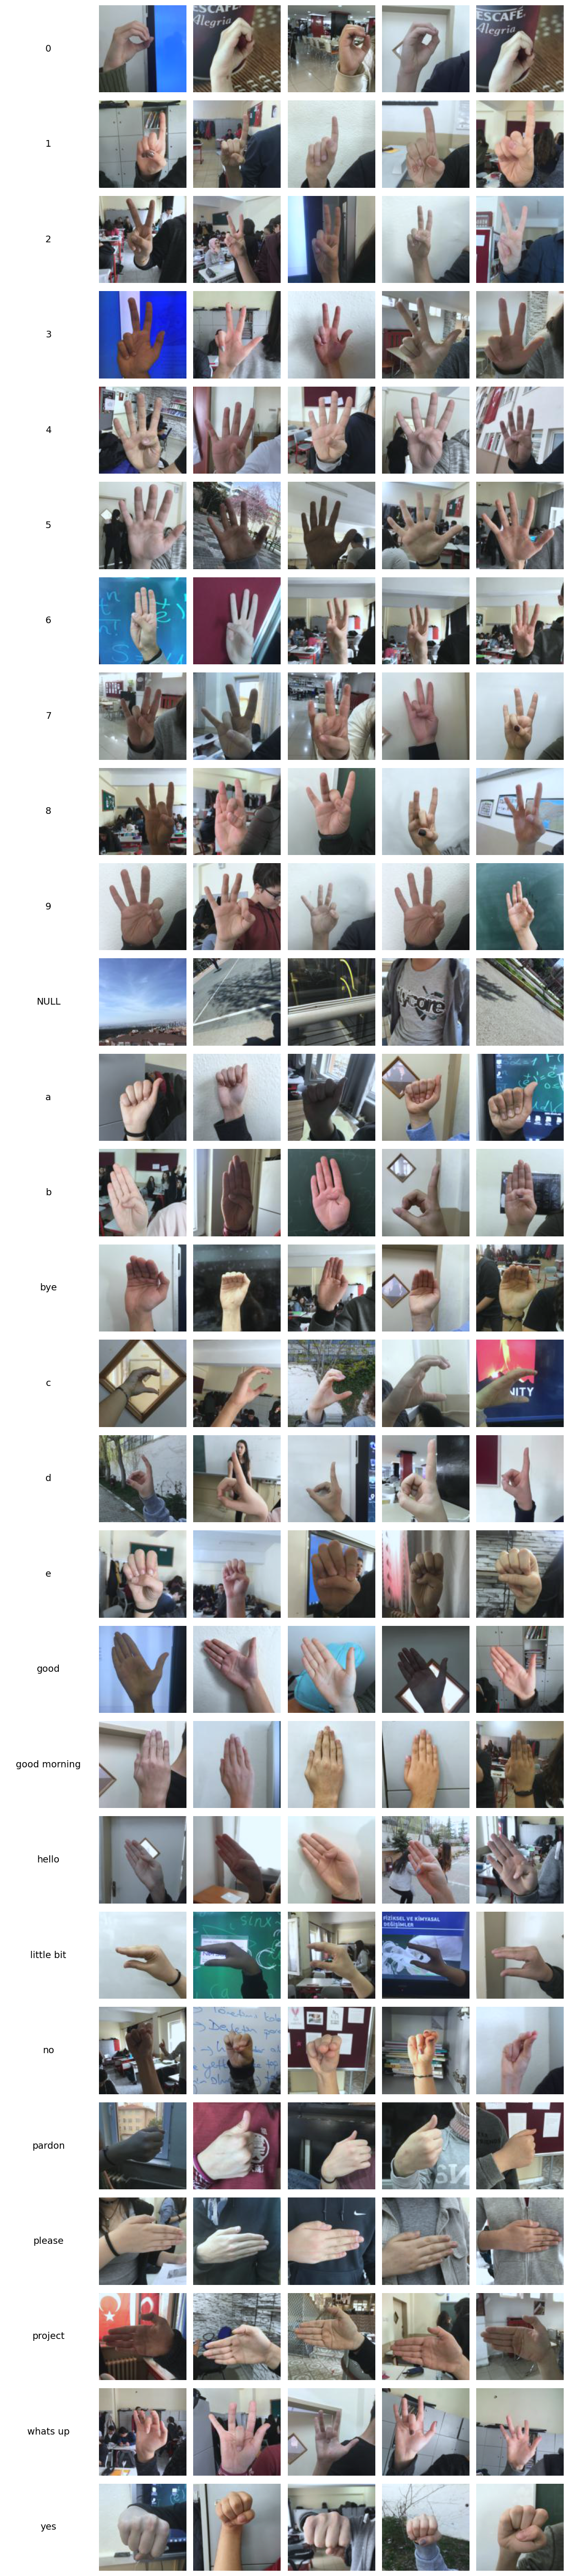

In [13]:
import torch
import matplotlib.pyplot as plt

def visualize_images_per_class(dataset, label_encoder, mean, std, num_images=5):
    """
    Visualizes a few images from each class in the dataset.

    Args:
    - dataset: The dataset to sample from.
    - label_encoder: The LabelEncoder used to decode labels.
    - mean: The mean values for de-normalization (list of floats).
    - std: The standard deviation values for de-normalization (list of floats).
    - num_images: Number of images to display per class.
    """
    # Get class names from the LabelEncoder
    dataset_classes = label_encoder.classes_

    # Create a mapping from class names to indices
    class_to_indices = {cls: [] for cls in dataset_classes}

    # Group indices by class
    for idx, (_, label) in enumerate(dataset):
        class_name = label_encoder.inverse_transform([label])[0]  # Decode label to class name
        if len(class_to_indices[class_name]) < num_images:
            class_to_indices[class_name].append(idx)
        if all(len(indices) == num_images for indices in class_to_indices.values()):
            break

    # Plot the images
    num_classes = len(dataset_classes)
    fig, axes = plt.subplots(num_classes, num_images + 1, figsize=((num_images + 1) * 2, num_classes * 2))

    for cls_idx, cls_name in enumerate(dataset_classes):
        indices = class_to_indices[cls_name]  # Use class name to access the indices

        # Add class name in the first column of each row
        axes[cls_idx, 0].text(0.5, 0.5, cls_name, fontsize=14, ha='center', va='center')
        axes[cls_idx, 0].axis("off")  # Turn off axis for the class name cell

        # Now display the images in the corresponding row
        for img_idx, data_idx in enumerate(indices):
            img, label = dataset[data_idx]
            ax = axes[cls_idx, img_idx + 1]  # Shift by 1 for the image columns

            # Prepare the image for display
            img = img.permute(1, 2, 0)  # Convert CHW to HWC
            img = img * torch.tensor(std).view(1, 1, -1) + torch.tensor(mean).view(1, 1, -1)  # De-normalize
            img = torch.clamp(img, 0, 1)  # Clip values to valid range

            ax.imshow(img)
            ax.axis("off")  # Turn off axis for images

    plt.tight_layout()
    plt.show()

# Example Usage
# Assuming you have 'dataset', 'dataset.label_encoder', 'computed_mean', and 'computed_std'
visualize_images_per_class(dataset, dataset.label_encoder, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], num_images=5)


In [14]:
import hashlib
import torch
from tqdm import tqdm

# Function to compute hash of a tensor
def compute_hash(image_tensor):
    # Ensure the tensor is on CPU and converted to bytes
    image_bytes = image_tensor.cpu().numpy().tobytes()
    # Compute MD5 hash
    return hashlib.md5(image_bytes).hexdigest()

# Detect duplicates
hashes = {}
duplicates = []

# Assuming you are using a DataLoader for the dataset
for batch in tqdm(loader, desc="Processing batches"):
    images, labels = batch
    for idx, image in enumerate(images):
        image_hash = compute_hash(image)
        
        # Check if the hash already exists
        if image_hash in hashes:
            # Duplicate found, append the file paths (or any other relevant info)
            duplicates.append((hashes[image_hash], labels[idx]))
        else:
            # Store the hash with the corresponding label or file path
            hashes[image_hash] = labels[idx]  # Or you could store dataset.samples[idx][0] for file path

print(f"Found {len(duplicates)} duplicate images.")


Processing batches: 100%|██████████| 36/36 [00:01<00:00, 22.33it/s]

Found 13 duplicate images.


Calculating per-image statistics: 100%|██████████| 36/36 [00:01<00:00, 33.02it/s]


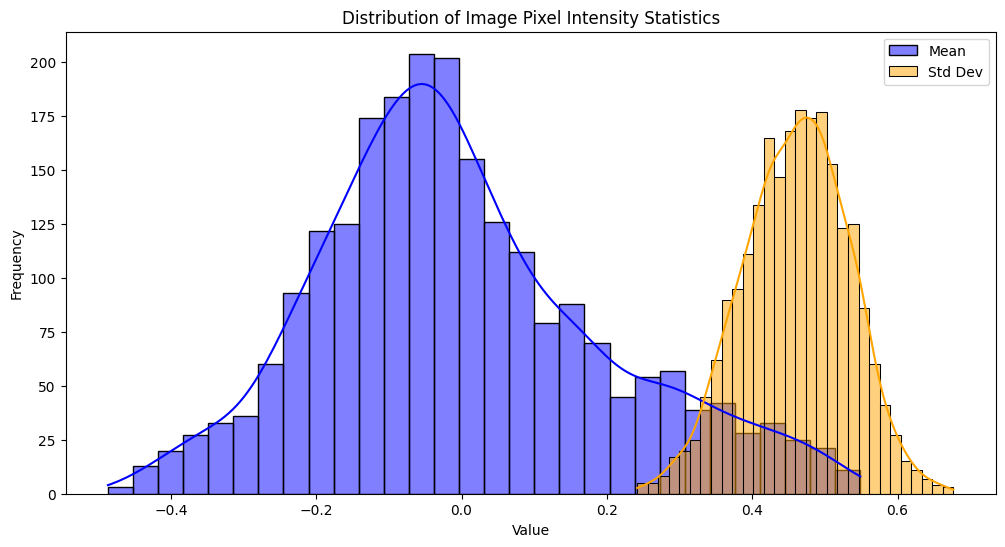

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lists to store per-image mean and std deviation
image_means = []
image_stds = []

# Iterate over DataLoader
for images, _ in tqdm(loader, desc="Calculating per-image statistics"):
    # Compute mean and std for each image in the batch
    for img in images:
        img = img.view(-1)  # Flatten the image
        image_means.append(img.mean().item())
        image_stds.append(img.std().item())

# Plot histograms
plt.figure(figsize=(12, 6))
sns.histplot(image_means, bins=30, kde=True, color='blue', label='Mean')
sns.histplot(image_stds, bins=30, kde=True, color='orange', label='Std Dev')
plt.legend()
plt.title('Distribution of Image Pixel Intensity Statistics')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()